**Transferencia de aprendizaje aplicado a perros y gatos\**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import shutil

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
import os
# Ver qué hay en tu Drive
print(os.listdir('/content/drive/MyDrive/'))

['Classroom', 'GUIA_EXCOBA.pdf', 'CERTIFICADO_427740.pdf', 'fisicaserway_Vol1.pdf', 'Tarea 1.pdf', 'Práctica 5.pdf', 'Conceptos de física que considero importantes.pdf', 'comprobanteVigenciaDerechos46220438819 (1).pdf', 'comprobanteVigenciaDerechos46220438819 (2).pdf', 'Práctica 10 energía.pdf', 'Práctica 11 recipientes.pdf', 'Práctica 12 elementos de un circuito eléctico.pdf', 'Colab Notebooks', 'Práctica final.pdf', 'Jan 10, 1.26 PM\u200b.aac', 'Dancing with Qubits How quantum computing works and how it can change the world (Robert S. Sutor) (z-lib.org).pdf', 'Carátula IMSS.pdf', 'Jan 19, 7.16 PM\u200b.aac', 'Jan 29, 2.25 PM\u200b.aac', 'Feb 1, 3.11 PM\u200b.aac', 'INE_MAMA.pdf', 'INE_OscarR_Sánchez.pdf', 'Reporte 1.gdoc', 'Documento sin título (1).gdoc', 'Práctica 3 laboratorio de mecánica.gdoc', 'Práctica 4 laboratorio de mecánica..gdoc', 'Práctica 5 laboratorio de mecánica.gdoc', 'CERTIFICADO_BACHILLERATO.pdf', 'Pago_Constancia.pdf', 'CONSTANCIA DE ESTUDIOS (3).pd

In [4]:
# Verificamos la estructura del dataset

train_dir = '/content/drive/MyDrive/Train'

print("Verificando contenido de la carpeta Train:")
items = os.listdir(train_dir)
print(f"Total de items: {len(items)}\n")

# Mostrar primeros 10 items
for item in items[:10]:
    item_path = os.path.join(train_dir, item)
    if os.path.isdir(item_path):
        num_files = len(os.listdir(item_path))
        print(f"  📁 {item}: {num_files} archivos")
    else:
        print(f"  📄 {item}")

print("\n✓ Verificación completa")

Verificando contenido de la carpeta Train:
Total de items: 4340

  📄 dog.8984.jpg
  📄 cat.11502.jpg
  📄 dog.12346.jpg
  📄 cat.2055.jpg
  📄 dog.6765.jpg
  📄 cat.4430.jpg
  📄 dog.9456.jpg
  📄 dog.8990.jpg
  📄 cat.11516.jpg
  📄 cat.10608.jpg

✓ Verificación completa


In [5]:
# Copiar la carpeta Train de Drive a Colab
source = '/content/drive/MyDrive/Train'
destination = '/content/Train'

print("Copiando dataset a Colab (esto puede tardar unos minutos)...")
shutil.copytree(source, destination)
print(f"✓ Dataset copiado a {destination}")

# Ahora trabajamos con esta ruta local
train_dir = '/content/Train'

Copiando dataset a Colab (esto puede tardar unos minutos)...
✓ Dataset copiado a /content/Train


In [6]:
# PASO 3: Organizar imágenes en subcarpetas Cat y Dog

train_dir = '/content/Train'

# Crear carpetas Cat y Dog
cat_dir = os.path.join(train_dir, 'Cat')
dog_dir = os.path.join(train_dir, 'Dog')

os.makedirs(cat_dir, exist_ok=True)
os.makedirs(dog_dir, exist_ok=True)

# Mover imágenes según su nombre
cat_count = 0
dog_count = 0

for filename in os.listdir(train_dir):
    file_path = os.path.join(train_dir, filename)

    # Saltar si es una carpeta
    if os.path.isdir(file_path):
        continue

    # Mover según el prefijo del nombre
    if filename.lower().startswith('cat'):
        shutil.move(file_path, os.path.join(cat_dir, filename))
        cat_count += 1
    elif filename.lower().startswith('dog'):
        shutil.move(file_path, os.path.join(dog_dir, filename))
        dog_count += 1

print(f"Imágenes reorganizadas:")
print(f"  - Gatos: {cat_count} imágenes")
print(f"  - Perros: {dog_count} imágenes")

Imágenes reorganizadas:
  - Gatos: 2174 imágenes
  - Perros: 2166 imágenes


In [7]:
# Cargamos el dataset con Tensorflow
import tensorflow as tf

train_dir = '/content/Train'

# Parámetros
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

# Cargar dataset de entrenamiento (80%)
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    shuffle=True,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# Cargar dataset de validación (20%)
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    shuffle=True,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# Verificar las clases
class_names = train_dataset.class_names
print(f"\n✓ Clases detectadas: {class_names}")
print(f"✓ Batches de entrenamiento: {len(train_dataset)}")
print(f"✓ Batches de validación: {len(validation_dataset)}")

Found 4340 files belonging to 2 classes.
Using 3472 files for training.
Found 4340 files belonging to 2 classes.
Using 868 files for validation.

✓ Clases detectadas: ['Cat', 'Dog']
✓ Batches de entrenamiento: 109
✓ Batches de validación: 28


In [8]:
# Optimizar el rendimiento
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

print("✓ Datasets optimizados y listos para entrenar")

✓ Datasets optimizados y listos para entrenar


In [9]:
# Creamos el MODELO BASE con Transfer Learning

#Definamos los parametros de entrada de las imagenes
IMG_SHAPE = IMG_SIZE + (3,)  # (160, 160, 3)

# Cargamos MobileNetV2 preentrenado
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SHAPE,
    include_top=False,  # No incluir las ultimas capas del modelo (las capas de clasificación)
    weights='imagenet'   # Cargamos los pesos preentrenados
)

# Congelamos el modelo base porque estos pesos ya son muy buenos para detectar características visuales. Solo entrenaremos las nuevas capas que agregaremos encima
base_model.trainable = False

print(f"✓ Modelo base: {base_model.name}")
print(f"  Capas totales: {len(base_model.layers)}")

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
✓ Modelo base: mobilenetv2_1.00_160
  Capas totales: 154


In [10]:
#7- Crear función para el modelo con hiperparámetros

def create_model(learning_rate=0.0001, dropout_rate=0.2, dense_units=None):
    """
    Función que crea el modelo con hiperparámetros configurables

    Args:
        learning_rate: Tasa de aprendizaje del optimizador
        dropout_rate: Porcentaje de dropout para regularización
        dense_units: Si es None, no agrega capa densa extra.
                     Si es un número, agrega una capa densa con esas unidades
    """
    preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

    # Construimos el modelo
    inputs = tf.keras.Input(shape=IMG_SHAPE)
    x = preprocess_input(inputs)
    x = base_model(x, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)

    # Agregamos una capa densa adicional si se especifica
    if dense_units is not None:
        x = tf.keras.layers.Dense(dense_units, activation='relu')(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)

    # Capa de salida
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs, outputs)

    # Compilamos
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

print("Función del modelo con hiperparámetros creada")

Función del modelo con hiperparámetros creada


In [11]:
# 8- Configuramos los hiperparámetros a probar

import itertools
import pandas as pd

# Definimos los hiperparámetros a probar
learning_rates = [0.0001, 0.001]
dropout_rates = [0.2, 0.5]
dense_units_options = [None, 64]  # None = sin capa extra, 64 = con capa de 64 neuronas

# Creamos todas las combinaciones
param_combinations = list(itertools.product(learning_rates, dropout_rates, dense_units_options))

print(f"Configuración de GridSearch:")
print(f"  - Learning rates: {learning_rates}")
print(f"  - Dropout rates: {dropout_rates}")
print(f"  - Dense units: {dense_units_options}")
print(f"\n Total de combinaciones a probar: {len(param_combinations)}")

Configuración de GridSearch:
  - Learning rates: [0.0001, 0.001]
  - Dropout rates: [0.2, 0.5]
  - Dense units: [None, 64]

 Total de combinaciones a probar: 8


In [12]:
# 9- Ejecutamos el GridSearch Manual

# Almacenamos resultados aqui:
results = []
epochs_per_test = 5  # Menos epochs para probar rápido

print("\n" + "="*70)
print("Iniciando GrindSearch...")
print("="*70)

for i, (lr, dropout, units) in enumerate(param_combinations, 1):
    print(f"\n{'='*70}")
    print(f"🔄 Prueba {i}/{len(param_combinations)}")
    print(f"{'='*70}")
    print(f"  Learning Rate: {lr}")
    print(f"  Dropout Rate: {dropout}")
    print(f"  Dense Units: {units if units else 'Sin capa extra'}")
    print(f"{'='*70}\n")

    # Creamos nuestro modelo con estos hiperparámetros
    model_test = create_model(
        learning_rate=lr,
        dropout_rate=dropout,
        dense_units=units
    )

    # Entrenamos
    history = model_test.fit(
        train_dataset,
        validation_data=validation_dataset,
        epochs=epochs_per_test,
        verbose=1
    )

    # Extraemos métricas
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]
    best_val_acc = max(history.history['val_accuracy'])

    # Guardamos resultados
    results.append({
        'learning_rate': lr,
        'dropout_rate': dropout,
        'dense_units': units if units else 'None',
        'final_train_accuracy': final_train_acc,
        'final_val_accuracy': final_val_acc,
        'best_val_accuracy': best_val_acc,
        'final_train_loss': final_train_loss,
        'final_val_loss': final_val_loss
    })

    print(f"\n Resultados de esta prueba:")
    print(f"  - Final Training Accuracy: {final_train_acc:.4f}")
    print(f"  - Final Validation Accuracy: {final_val_acc:.4f}")
    print(f"  - Best Validation Accuracy: {best_val_acc:.4f}")

print("\n" + "="*70)
print("GRIDSEARCH COMPLETADO")
print("="*70)


Iniciando GrindSearch...

🔄 Prueba 1/8
  Learning Rate: 0.0001
  Dropout Rate: 0.2
  Dense Units: Sin capa extra

Epoch 1/5
109/109 ━━━━━━━━━━━━━━━━━━━━ 108s 931ms/step - accuracy: 0.6004 - loss: 0.6769 - val_accuracy: 0.8733 - val_loss: 0.3830
Epoch 2/5
109/109 ━━━━━━━━━━━━━━━━━━━━ 94s 866ms/step - accuracy: 0.8752 - loss: 0.3655 - val_accuracy: 0.9389 - val_loss: 0.2427
Epoch 3/5
109/109 ━━━━━━━━━━━━━━━━━━━━ 139s 839ms/step - accuracy: 0.9333 - loss: 0.2347 - val_accuracy: 0.9539 - val_loss: 0.1811
Epoch 4/5
109/109 ━━━━━━━━━━━━━━━━━━━━ 141s 839ms/step - accuracy: 0.9596 - loss: 0.1779 - val_accuracy: 0.9654 - val_loss: 0.1479
Epoch 5/5
109/109 ━━━━━━━━━━━━━━━━━━━━ 90s 826ms/step - accuracy: 0.9610 - loss: 0.1494 - val_accuracy: 0.9654 - val_loss: 0.1274

 Resultados de esta prueba:
  - Final Training Accuracy: 0.9603
  - Final Validation Accuracy: 0.9654
  - Best Validation Accuracy: 0.9654

🔄 Prueba 2/8
  Learning Rate: 0.0001
  Dropout Rate: 0.2
  Dense Units: 64

Epoch 1/5
109/1


📊 RESULTADOS DEL GRID SEARCH (ordenados por mejor accuracy)
 learning_rate  dropout_rate dense_units  final_train_accuracy  final_val_accuracy  best_val_accuracy  final_train_loss  final_val_loss
        0.0010           0.5        None              0.976959            0.983871           0.983871          0.059209        0.066309
        0.0010           0.5          64              0.977823            0.980415           0.983871          0.055262        0.055673
        0.0001           0.5          64              0.956509            0.980415           0.980415          0.118802        0.064005
        0.0001           0.2          64              0.979839            0.979263           0.979263          0.059528        0.064725
        0.0010           0.2          64              0.988191            0.979263           0.979263          0.030725        0.062968
        0.0010           0.2        None              0.987327            0.979263           0.979263          0.041553    

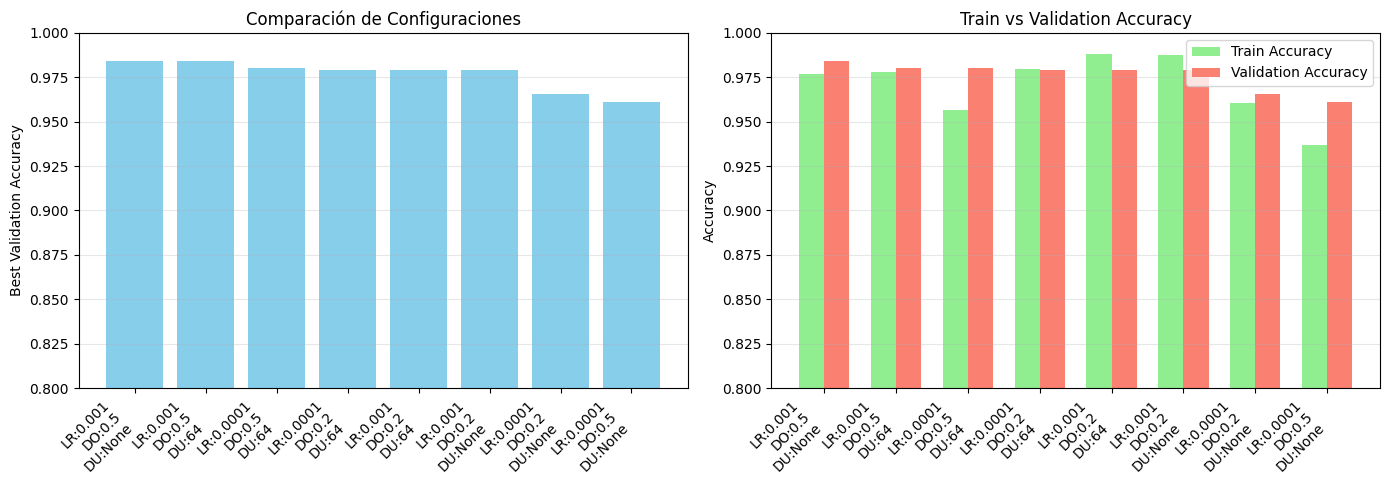

In [13]:
# 10- Analisis de resultados del GridSearch

# Creamos DataFrame con resultados
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('best_val_accuracy', ascending=False)

print("\n" + "="*70)
print("📊 RESULTADOS DEL GRID SEARCH (ordenados por mejor accuracy)")
print("="*70)
print(results_df.to_string(index=False))

# Mostramos el mejor modelo
print("\n" + "="*70)
print("🏆 MEJOR CONFIGURACIÓN")
print("="*70)
best = results_df.iloc[0]
print(f"  Learning Rate: {best['learning_rate']}")
print(f"  Dropout Rate: {best['dropout_rate']}")
print(f"  Dense Units: {best['dense_units']}")
print(f"  Best Validation Accuracy: {best['best_val_accuracy']:.4f}")
print(f"  Final Validation Accuracy: {best['final_val_accuracy']:.4f}")
print(f"  Final Training Accuracy: {best['final_train_accuracy']:.4f}")

# Visualizamos comparación
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))

# Gráfica 1: Validation Accuracy por configuración
plt.subplot(1, 2, 1)
x_labels = [f"LR:{r['learning_rate']}\nDO:{r['dropout_rate']}\nDU:{r['dense_units']}"
            for _, r in results_df.iterrows()]
plt.bar(range(len(results_df)), results_df['best_val_accuracy'], color='skyblue')
plt.xticks(range(len(results_df)), x_labels, rotation=45, ha='right')
plt.ylabel('Best Validation Accuracy')
plt.title('Comparación de Configuraciones')
plt.grid(axis='y', alpha=0.3)
plt.ylim([0.8, 1.0])  # Ajusta según tus resultados

# Gráfica 2: Train vs Validation Accuracy
plt.subplot(1, 2, 2)
x_pos = range(len(results_df))
width = 0.35
plt.bar([p - width/2 for p in x_pos], results_df['final_train_accuracy'],
        width, label='Train Accuracy', color='lightgreen')
plt.bar([p + width/2 for p in x_pos], results_df['final_val_accuracy'],
        width, label='Validation Accuracy', color='salmon')
plt.xticks(x_pos, x_labels, rotation=45, ha='right')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.ylim([0.8, 1.0])

plt.tight_layout()
plt.show()


🚀 ENTRENANDO MODELO FINAL CON MEJORES HIPERPARÁMETROS

Parámetros del modelo final:
  Learning Rate: 0.001
  Dropout Rate: 0.5
  Dense Units: None
Epoch 1/15
109/109 ━━━━━━━━━━━━━━━━━━━━ 108s 922ms/step - accuracy: 0.7626 - loss: 0.4762 - val_accuracy: 0.9654 - val_loss: 0.1025
Epoch 2/15
109/109 ━━━━━━━━━━━━━━━━━━━━ 93s 853ms/step - accuracy: 0.9613 - loss: 0.1046 - val_accuracy: 0.9735 - val_loss: 0.0781
Epoch 3/15
109/109 ━━━━━━━━━━━━━━━━━━━━ 142s 859ms/step - accuracy: 0.9751 - loss: 0.0821 - val_accuracy: 0.9793 - val_loss: 0.0703
Epoch 4/15
109/109 ━━━━━━━━━━━━━━━━━━━━ 93s 848ms/step - accuracy: 0.9782 - loss: 0.0683 - val_accuracy: 0.9781 - val_loss: 0.0673
Epoch 5/15
109/109 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.9808 - loss: 0.0619 - val_accuracy: 0.9770 - val_loss: 0.0668
Epoch 6/15
109/109 ━━━━━━━━━━━━━━━━━━━━ 94s 866ms/step - accuracy: 0.9844 - loss: 0.0496 - val_accuracy: 0.9781 - val_loss: 0.0635
Epoch 7/15
109/109 ━━━━━━━━━━━━━━━━━━━━ 98s 901ms/step - accuracy:

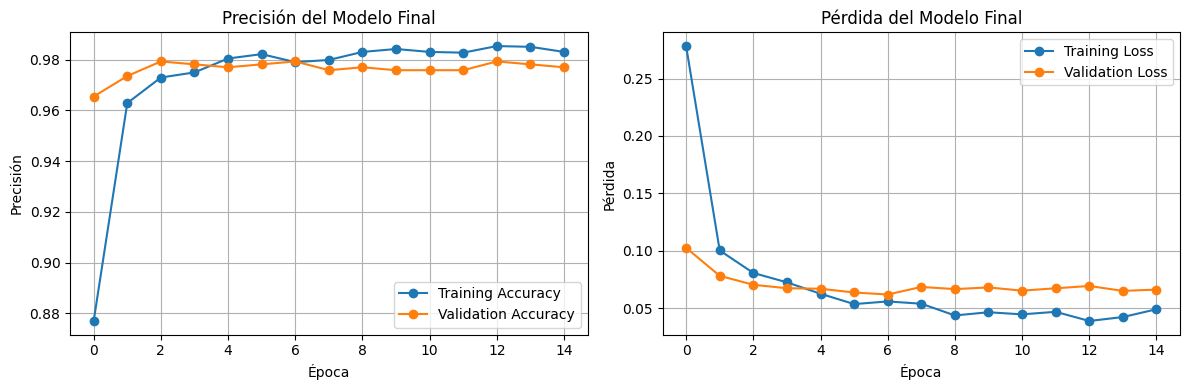


🎯 Mejor Validation Accuracy del modelo final: 0.9793 en época 3


In [14]:
# 11- Entrenamos el modelo final con los mejores hiperparámetros

print("\n" + "="*70)
print("🚀 ENTRENANDO MODELO FINAL CON MEJORES HIPERPARÁMETROS")
print("="*70)

# Creamos modelo con los mejores hiperparámetros
best_params = results_df.iloc[0]
final_model = create_model(
    learning_rate=best_params['learning_rate'],
    dropout_rate=best_params['dropout_rate'],
    dense_units=None if best_params['dense_units'] == 'None' else int(best_params['dense_units'])
)

print(f"\nParámetros del modelo final:")
print(f"  Learning Rate: {best_params['learning_rate']}")
print(f"  Dropout Rate: {best_params['dropout_rate']}")
print(f"  Dense Units: {best_params['dense_units']}")

# Entrenamos con más épocas
final_epochs = 15

final_history = final_model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=final_epochs,
    verbose=1
)

print("\n✓ Modelo final entrenado")

# Para visualizar los resultados finales tenemos:
acc = final_history.history['accuracy']
val_acc = final_history.history['val_accuracy']
loss = final_history.history['loss']
val_loss = final_history.history['val_loss']

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy', marker='o')
plt.plot(val_acc, label='Validation Accuracy', marker='o')
plt.legend()
plt.title('Precisión del Modelo Final')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss', marker='o')
plt.plot(val_loss, label='Validation Loss', marker='o')
plt.legend()
plt.title('Pérdida del Modelo Final')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.grid(True)

plt.tight_layout()
plt.show()

best_final_val_acc = max(val_acc)
best_final_epoch = val_acc.index(best_final_val_acc) + 1
print(f"\n🎯 Mejor Validation Accuracy del modelo final: {best_final_val_acc:.4f} en época {best_final_epoch}")